# Profile likelihood for $\Lambda$CDM

In [1]:
from lkl_prof_functions import *

### Read in chains 

- Set chains_dir as the folder where chain .txt files are found 
- Set chain_file as the filename up until the .1.txt etc
- Any chain settings you want, although these are irrelevant 
- Set minimizer settings here. Eg. if you're looking for a global minimum (besides testing, global minimum should be on). 
- Minimizer settings also inherits from the .yaml file for global minimum!! Ensure global minimum is also sought there 

In [2]:
chain_file = 'lcdm_cmb_bao_sne_'
chains_dir = '/home2/karwal/lkl_prof/lcdm_tests_output/'
os.chdir(chains_dir)

settings = {'ignore_rows' : 0.2}

minimizer_settings = {'minimize': 
                                {   'method': 'bobyqa',
                                    'covmat' : 'auto',
#                                     'override_bobyqa' : {'seek_global_minimum': 'true'}
                                }
                      }
processes = 6

### Pick param to vary and increment

In [3]:
prof_param = 'H0'
prof_incr = 0.1
prof_min = 65.
prof_max = 74.

### Check for MCMC chains

In [4]:
try:
    mcmc_chains = mcsamples.loadMCSamples(chains_dir+chain_file, settings=settings)
    print("MCMC chains found. Moving on the checking minimum.")
except OSError:
    print("No chains found in "+chains_dir+" matching "+chain_file+" \nWill run mcmc first using file "+chains_dir+chain_file+'.yaml')
    mcmc_yaml = yaml_load_file(chains_dir+chain_file+'.yaml')
    try:
        mcmc_yaml['sampler']['mcmc']['Rminus1_stop'] = 0.1
    except KeyError:
        print("Error: Input yaml not set up correctly for an mcmc run. Please ensure the sampler 'mcmc' is correctly set. ")
    if mcmc_yaml['output'].count('/') > 1:
        print("Error: For correct functioning of the code, please have the input .yaml file in the same directory as the output chains. Currently, output is: "+mcmc_yaml['output'])
        raise OSError
    run("mpirun -np "+str(processes)+" cobaya-run "+chain_file+".yaml", shell=True)


MCMC chains found. Moving on the checking minimum.


## Set up profile likelihood

### Check if minimizer was run on all chains previously 
And if not, use above defined minimizer settings to run it. 

In [5]:
if not check_global_min(mcmc_chains=mcmc_chains, chains_dir=chains_dir, chain_file=chain_file):
    mcmc_yaml = yaml_load_file(chains_dir+chain_file+'.input.yaml')
    mcmc_yaml['sampler'] = minimizer_settings
    with open(chains_dir + chain_file + '.minimize.input.yaml', 'w') as yaml_file:
        dump(min_yaml, yaml_file, default_flow_style=False)

    run_minimizer(chain_file=chain_file, yaml_ext='', debug=False, processes=processes)    

check_global_min: Found previously run MCMC chains and global minimizer. 


### Add minimized point to lkl profile text file 

So: 
1) load the global minimum file. 

2) check if we have a file with prof lkl values. 

    * If yes, check that it has the same parameters and in the right order. Proceed. 
    * If no file, start it and write the first line as param names. Proceed. 
    * If file yes, but parameters don't match, then print an error. Stop. 
    
2) check if global minimum params have already been written (first line of file)

    * If parameters are written, check that they match global minimum. Don't write them again
    * If parameters are written but don't match, spit out error. 
    * If no params written, add this current ML values for all parameters in append mode

In [6]:
param_names, param_ML, MLs = read_minimum(chains_dir, chain_file, prof_incr, extension='')

In [7]:
global_ML = deepcopy(MLs)
param_order = param_names

In [8]:
try: 
    if not match_param_names(param_names, chains_dir=chains_dir, chain_file=chain_file, prof_incr=prof_incr):
        raise FileExistsError
except FileNotFoundError:
    extension = '_lkl_profile.txt'
    if prof_incr > 0:
        extension = '_p'+extension
    if prof_incr < 0:
        extension = '_n'+extension
    print("File not found. Starting a new file now: " + chains_dir + chain_file + extension + '\n')
    with open(chains_dir + chain_file + extension, 'w') as lkl_txt:
        lkl_txt.write("#")
        for param_recorded in param_names:
            lkl_txt.write("\t %s" % param_recorded)
        lkl_txt.write("\n")

match_param_names: Found existing file with correct name and parameters / parameter sequence. Will append to it. 
/home2/karwal/lkl_prof/lcdm_tests_output/lcdm_cmb_bao_sne__p_lkl_profile.txt


In [9]:
extension = '_lkl_profile.txt'
if prof_incr > 0:
    extension = '_p'+extension
if prof_incr < 0:
    extension = '_n'+extension
lkl_prof_table = np.loadtxt(chains_dir + chain_file + extension)
if lkl_prof_table.shape!=(0,):
    if not match_param_line(param_names, global_ML, chains_dir=chains_dir, chain_file=chain_file, loc=0, prof_incr=prof_incr):
        print("Something went wrong. The first line of the lkl_profile.txt file which should be global ML does not match the global ML in file \n"
             +chains_dir + chain_file + '.minimum')
        raise FileExistsError
else: 
    write_MLs(param_names, MLs, chains_dir=chains_dir, chain_file=chain_file, prof_incr=prof_incr)

## Likelihood profile 

### Set up lkl profile minimum input yaml file 
Only this should be read and manipulated by the rest of the code

Here I check that a "_lkl_prof" file has been created for the minimizer input yaml.

In [10]:
extension = '_lkl_prof'
if prof_incr > 0:
    extension = '_p'+extension
if prof_incr < 0:
    extension = '_n'+extension
try:
    lkl_pro_yaml = yaml_load_file(chains_dir+chain_file+extension+'.minimize.input.yaml')
except FileNotFoundError:
    run("cp "+chains_dir+chain_file+'.minimize.updated.yaml'+" "+chains_dir+chain_file+extension+'.minimize.input.yaml', shell=True)
    lkl_pro_yaml = yaml_load_file(chains_dir+chain_file+extension+'.minimize.input.yaml')

We already have param_names and MLs saved. Update the param_ML with the values from the last entry in _lkl_prof.txt in case we're restarting / continuing a run. 

In [11]:
param_ML = read_lkl_output(chains_dir=chains_dir, chain_file=chain_file, loc=-1, prof_incr=prof_incr)
MLs = dict(zip(param_names, param_ML))

## Run loop over increments of profile lkl param 

While we are within the bounds of the profile param we want to explore: 

1) check if the point we are currently at i.e. param_ML and MLs, matches the last entry in the lkl_prof table.

    - if it does, the last minimum was run and saved successfully. 
    - if not, check if a minimum file exists. 
        - if it does, read it in and save it in the lkl prof txt. minimum run successfully. 
        - if not, this happens when we have updated the yaml but the minimizer didn't finish. Run the yaml again without updating. 
        
2) check if minimum was run and saved. 

    - if yes, update the yaml and increment the prof lkl param, update all other params to new values from current ML. Assign the MLs values for the independent params in the yaml as new reference starting points. 
    
3) run the minimizer

4) save minimizer output 

In [ ]:
extension = '_lkl_prof'
if prof_incr > 0:
    extension = '_p'+extension
if prof_incr < 0:
    extension = '_n'+extension
while ((MLs[prof_param] < prof_max) and (MLs[prof_param] > prof_min)):
    last_entry_matches_current_params = match_param_line(param_names, MLs, chains_dir=chains_dir, chain_file=chain_file, loc=-1, prof_incr=prof_incr)
    if last_entry_matches_current_params:
        run('rm '+chains_dir + chain_file + extension + '.minimum*', shell=True)
        minimum_successfully_run_and_saved = True
    else:
        try:
            param_names, param_ML, MLs = read_minimum(chains_dir, chain_file)
            write_MLs(param_order, MLs, chains_dir=chains_dir, chain_file=chain_file)
            run('rm '+chains_dir + chain_file + extension + '.minimum*', shell=True)
            minimum_successfully_run_and_saved = True 
            print("-----> Minimizer run successfully for "+prof_param+" = "+str(MLs[prof_param]))
        except OSError:
            minimum_successfully_run_and_saved = False
            print("-----> Minimizer not run for "+prof_param+" = "+str(MLs[prof_param]))
            print("       Rerunning this point")

    if minimum_successfully_run_and_saved:
        increment_update_yaml(chains_dir, chain_file, MLs, lkl_pro_yaml, prof_param, prof_incr)
        run('rm '+chains_dir + chain_file + extension + '.minimize.updated.yaml', shell=True)

    run_minimizer(chain_file=chain_file, prof_incr=prof_incr, debug=False, processes=processes)

    param_names, param_ML, MLs = read_minimum(chains_dir, chain_file)

In [ ]:
param_names, param_ML, MLs = read_minimum(chains_dir, chain_file, prof_incr=prof_incr)
write_MLs(param_order, MLs, chains_dir=chains_dir, chain_file=chain_file, prof_incr=prof_incr)

### Don't run the exit if you want the rest of the nb to work!! 

This is just here for when you run the nb through the shell after converting it to a python script. 

Below this is some scrap code for plotting to do simple, quick checks. 

In [ ]:
exit

# Scrap code below

### Plot lkl profile
- Load proflkl param. Skip the first two rows because of proflkl output file error (bug now fixed)
- Use param_names to compare to, but eventually, this should be param_order for correct functioning. 

In [12]:
param_names, param_ML, MLs = read_minimum(chains_dir, chain_file, prof_incr)

- Load the $\chi^2$'s. Here, I'm doing each experiment separately because of a bug that messed up the proflkl output file. (bug now fixed) Note that this method might be more correct if you want to compare on $\chi^2$. The likelihood output by Cobaya includes normalisations and priors or something, such that $\left( -\log\mathcal{L} \right) \neq \frac{1}{2}\chi^2$
- Sum the $\chi^2$'s.

In [13]:
prof_param_values_p = np.loadtxt(chains_dir+chain_file+'_p_lkl_profile.txt', usecols=(np.where(param_order == prof_param)[0][0],))
prof_param_values_n = np.loadtxt(chains_dir+chain_file+'_n_lkl_profile.txt', usecols=(np.where(param_order == prof_param)[0][0],))
prof_param_values = np.concatenate( ( np.flip(prof_param_values_n), prof_param_values_p ) )

In [14]:
params_wanted = ['chi2__CMB', 'chi2__SN', 'chi2__BAO']
chis_p = np.loadtxt(chains_dir+chain_file+'_p_lkl_profile.txt', usecols=(np.where(param_order == i)[0][0] for i in params_wanted))
chis_p = np.array([ chis_p[i,0]+chis_p[i,1]+chis_p[i,2] for i in range(chis_p.shape[0]) ])
chis_n = np.loadtxt(chains_dir+chain_file+'_n_lkl_profile.txt', usecols=(np.where(param_order == i)[0][0] for i in params_wanted))
chis_n = np.array([ chis_n[i,0]+chis_n[i,1]+chis_n[i,2] for i in range(chis_n.shape[0]) ])
chis = np.concatenate( ( np.flip(chis_n), chis_p ) )

- Plot. That one should be obvs. 

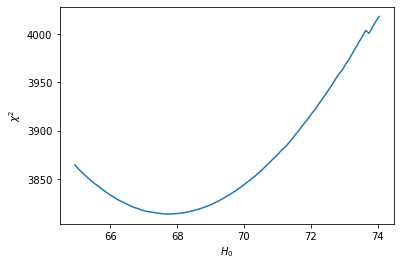

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot( prof_param_values, chis )
plt.ylabel(r'$\chi^2$')
plt.xlabel(r'$'+lkl_pro_yaml['params'][prof_param]['latex']+'$')
# plt.xlabel(prof_param)
plt.savefig(chains_dir+chain_file+'_lkl_profile.png')

plt.show()

### Visualise how each parameter shifts with prof lkl param 

- Load all columns of output proflkl file
- plot all parameters in the file against the profile lkl parameter (this is the same as plotting against [1,2,3...]

In [16]:
all_MLs_p = np.loadtxt(chains_dir+chain_file+'_p_lkl_profile.txt')
all_MLs_n = np.loadtxt(chains_dir+chain_file+'_n_lkl_profile.txt')
all_MLs = np.concatenate( (np.flip(all_MLs_n, 0),all_MLs_p) )

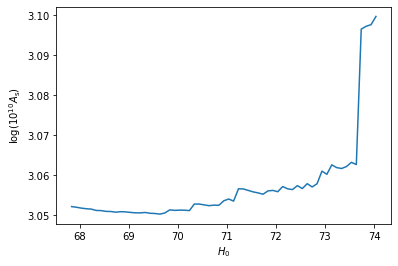

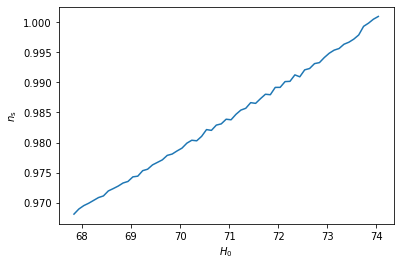

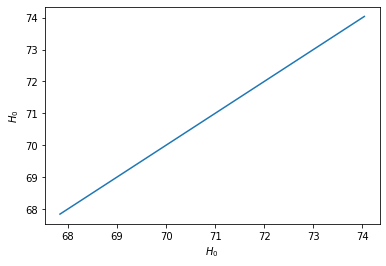

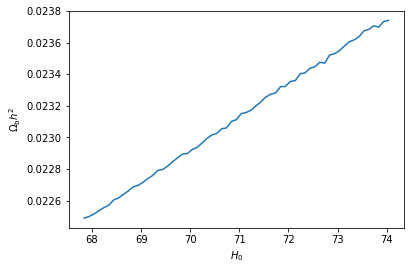

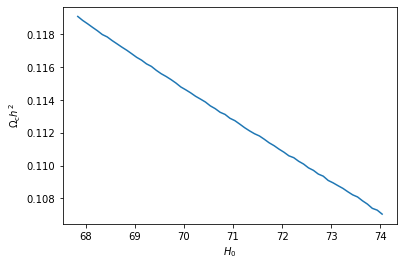

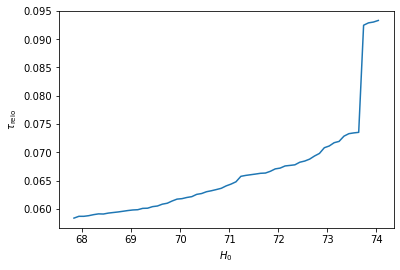

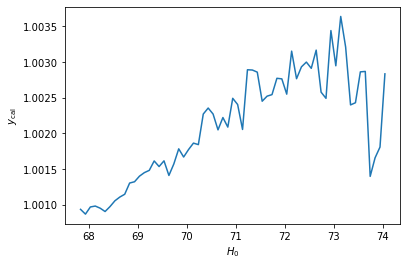

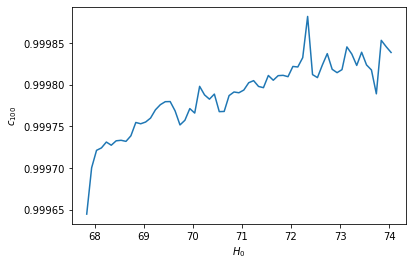

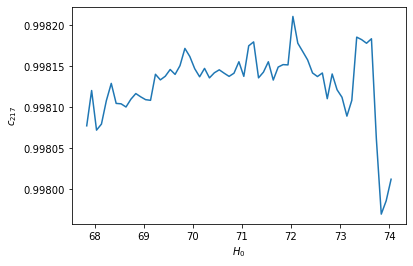

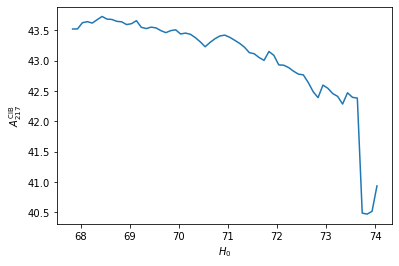

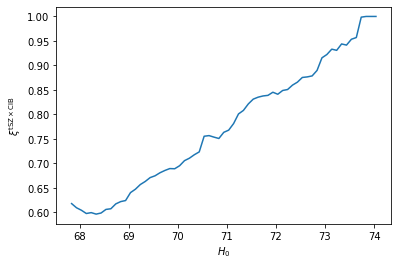

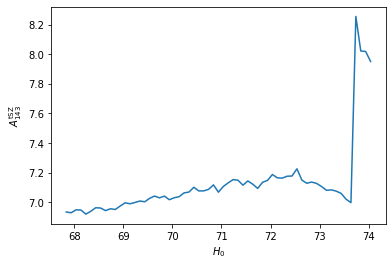

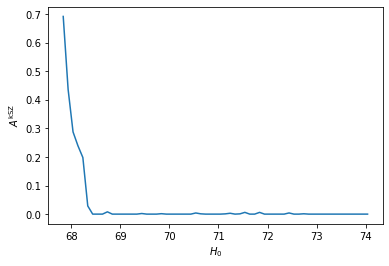

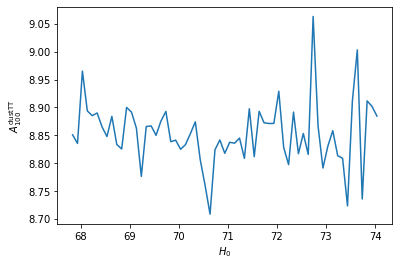

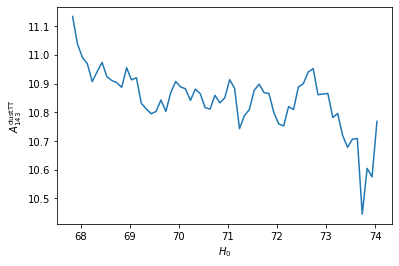

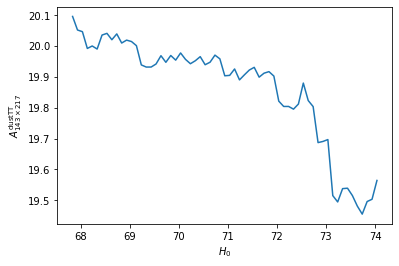

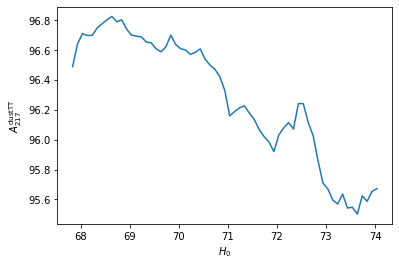

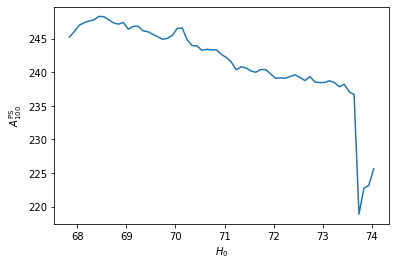

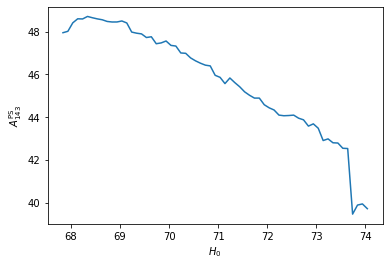

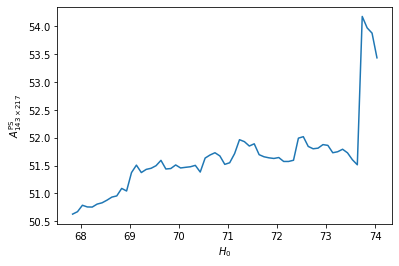

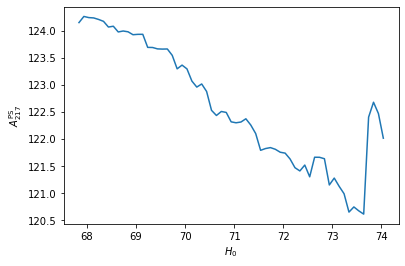

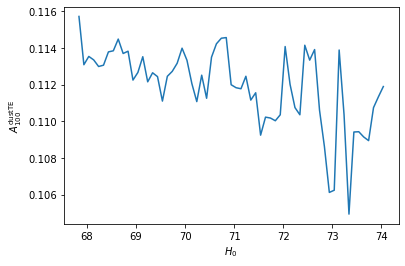

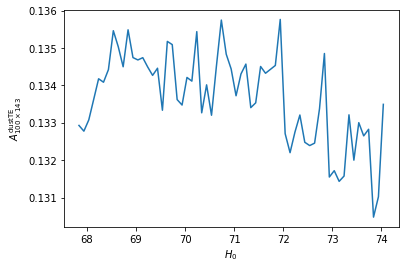

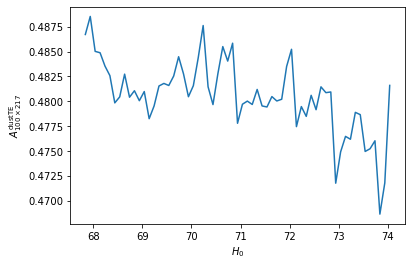

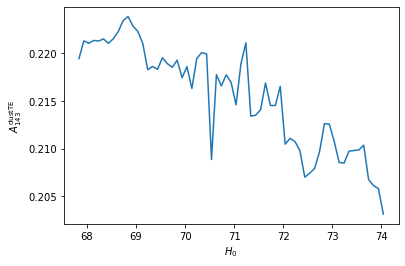

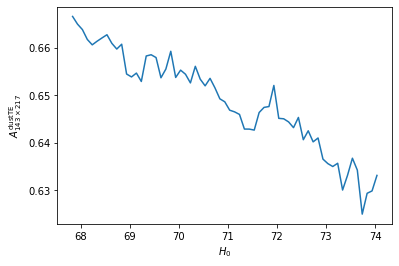

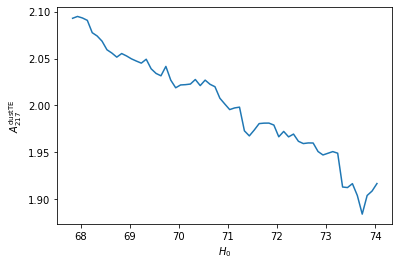

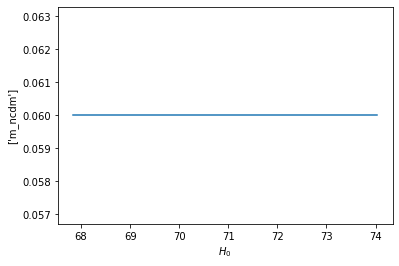

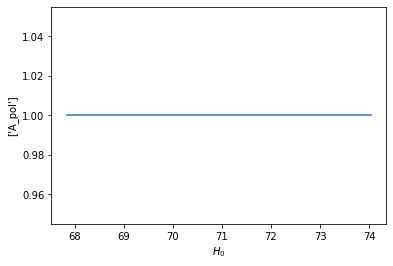

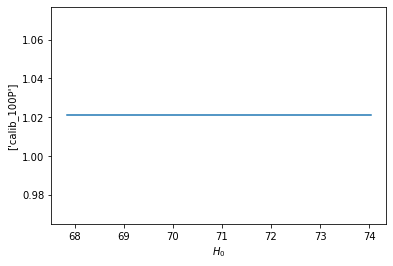

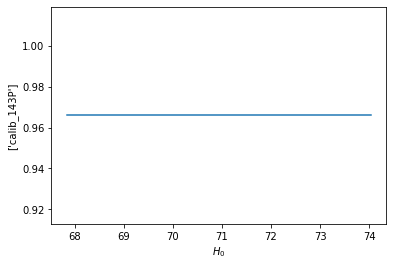

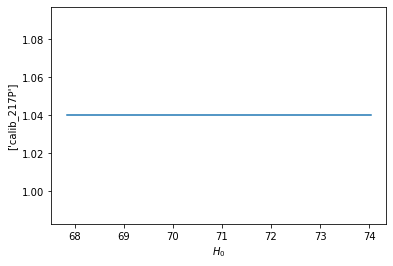

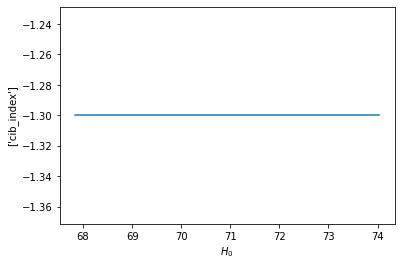

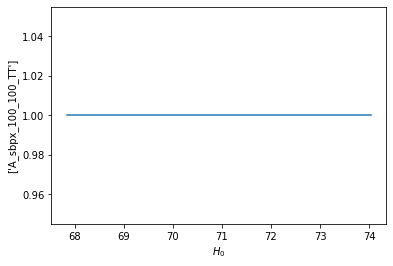

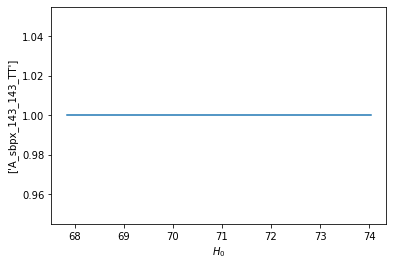

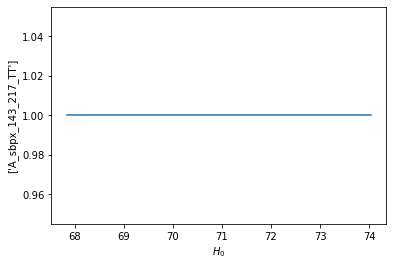

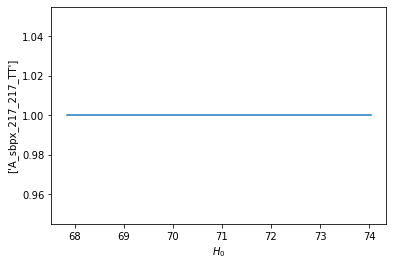

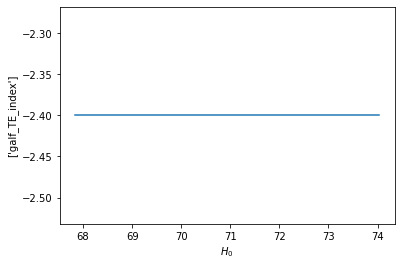

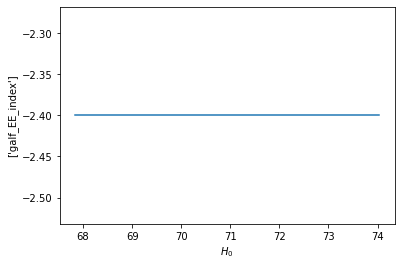

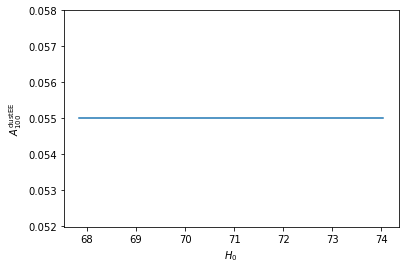

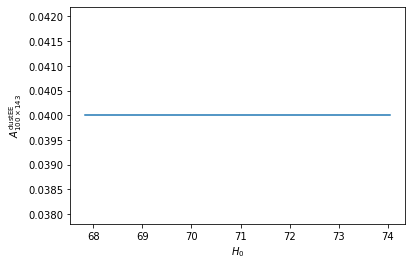

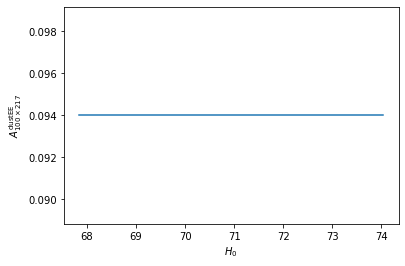

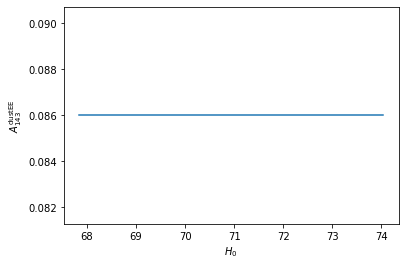

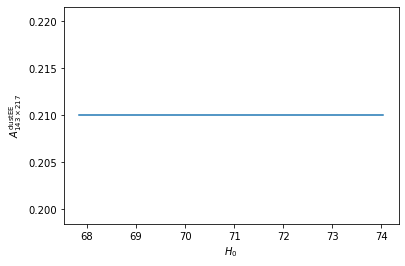

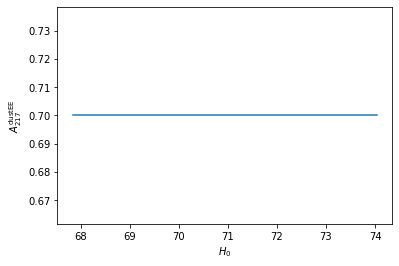

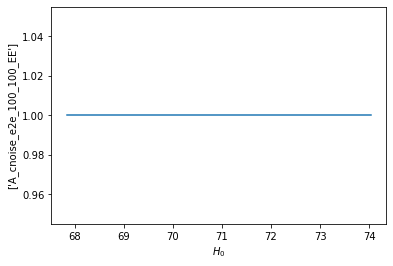

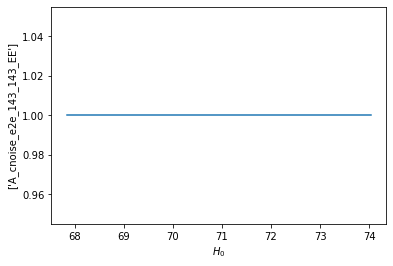

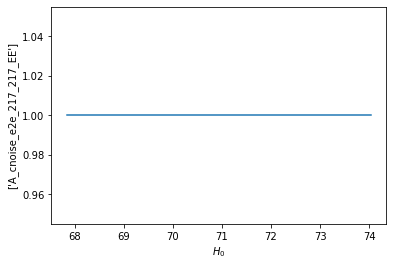

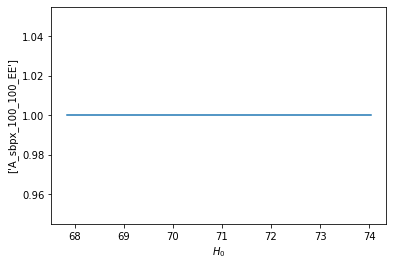

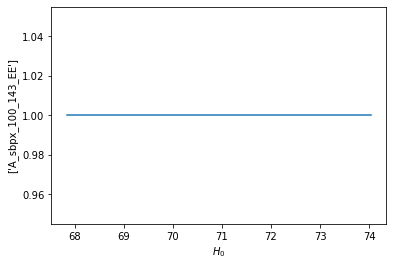

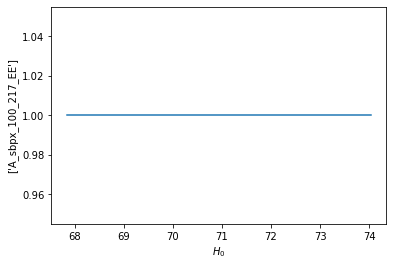

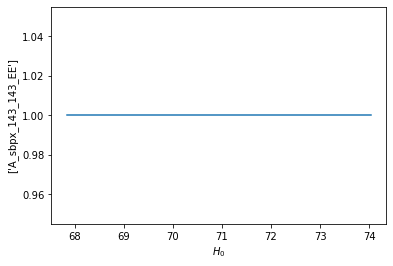

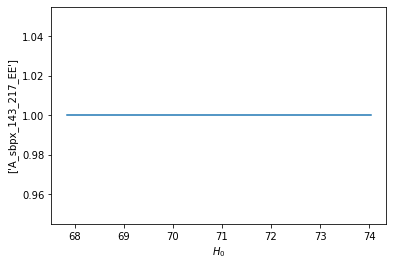

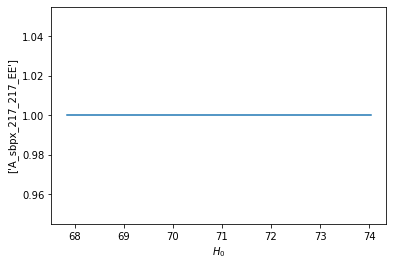

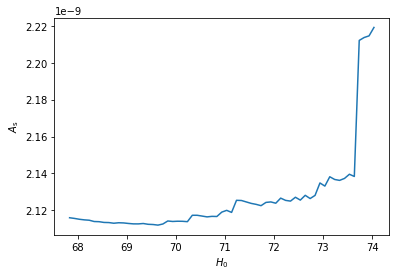

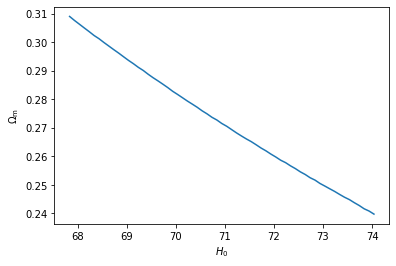

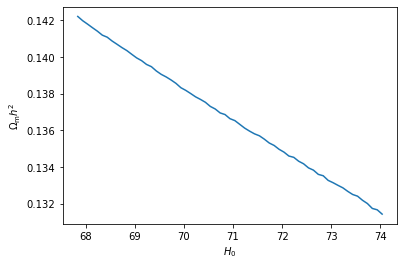

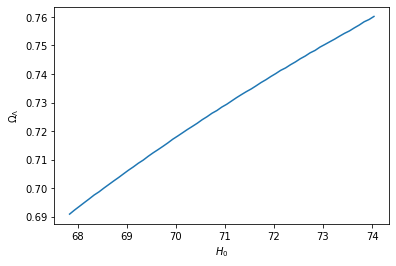

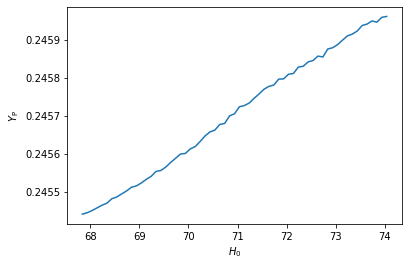

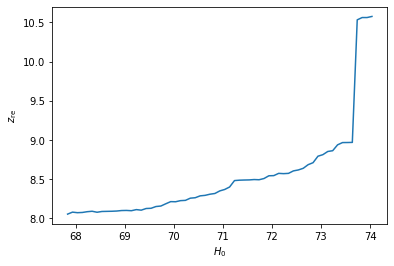

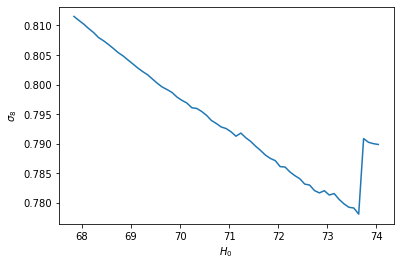

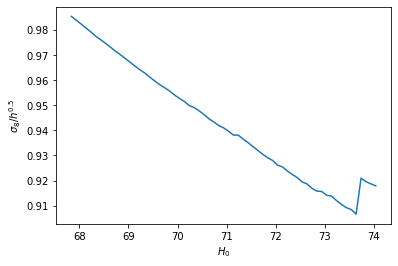

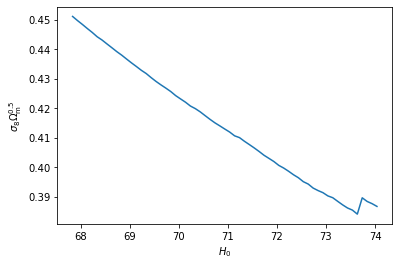

In [15]:
import matplotlib.pyplot as plt

all_MLs = np.loadtxt(chains_dir+chain_file+'_p_lkl_profile.txt')
for i in range(all_MLs.shape[0]):
    plt.plot( all_MLs[:, np.where(param_order == prof_param)[0][0] ], all_MLs[:,i] )
    try:
        plt.ylabel(r'$'+lkl_pro_yaml['params'][param_order[i]]['latex']+'$')
    except KeyError:
        plt.ylabel([param_order[i]])
#     plt.ylabel(param_order[i])
    plt.xlabel(r'$'+lkl_pro_yaml['params'][prof_param]['latex']+'$')
#     plt.xlabel(prof_param)
    plt.show()